In [1]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


Using TensorFlow backend.


# Load Data

In [2]:

(x_train_d, y_train_d), (x_test_d, y_test_d) = mnist.load_data()
# split train data to train/val
x_train, x_val, y_train, y_val = train_test_split(x_train_d, y_train_d, test_size=0.15, random_state=48)
train_sz = y_train.shape[0]
val_sz = y_val.shape[0] # assert tot sz = 60000
x_train = x_train.reshape(train_sz, 784) / 255
x_val = x_val.reshape(val_sz, 784)/255
x_test = x_test_d.reshape(10000, 784) / 255
y_test = y_test_d
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)


(51000, 784) (51000,)
(9000, 784) (9000,)
(10000, 784) (10000,)


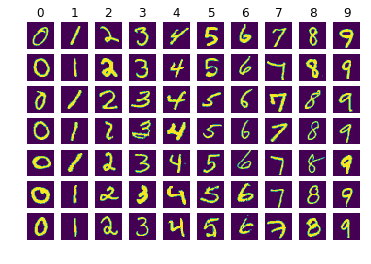

In [3]:
# plot data sample
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].reshape(28,28).astype('float64'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


# Autoencoder Model

In [5]:

# Model architecture include 6 simple feedforward layers.
# Enocoding into 10 features (bottleneck layer) and decoding back to the orig image
# Loss function of MSE (reduce the error between the net output to the orig input), Adam optimizer
autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu', input_shape=(784,)))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='elu'))
autoencoder.add(Dense(784,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())


# Train 

In [6]:
batch_sz = 1024
epochs_num = 13
trained_model = autoencoder.fit(x_train, x_train, batch_size=batch_sz, epochs=epochs_num, verbose=1, validation_data=(x_val, x_val))
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(x_train)  # bottleneck representation - clustering to 10 classes
decoded_output = autoencoder.predict(x_train)        # reconstruction
encoding_dim = 10


W0104 21:04:29.726206  8708 deprecation_wrapper.py:119] From c:\users\shimr\venv1\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 51000 samples, validate on 9000 samples
Epoch 1/13
51000/51000 [==============================] - 8s 148us/step - loss: 0.0828 - val_loss: 0.0542
Epoch 2/13
51000/51000 [==============================] - 7s 136us/step - loss: 0.0462 - val_loss: 0.0409
Epoch 3/13
51000/51000 [==============================] - 7s 136us/step - loss: 0.0376 - val_loss: 0.0349
Epoch 4/13
51000/51000 [==============================] - 7s 145us/step - loss: 0.0333 - val_loss: 0.0311
Epoch 5/13
51000/51000 [==============================] - 7s 147us/step - loss: 0.0295 - val_loss: 0.0279
Epoch 6/13
51000/51000 [==============================] - 7s 141us/step - loss: 0.0269 - val_loss: 0.0258
Epoch 7/13
51000/51000 [==============================] - 6s 112us/step - loss: 0.0250 - val_loss: 0.0243
Epoch 8/13
51000/51000 [==============================] - 7s 140us/step - loss: 0.0236 - val_loss: 0.0230
Epoch 9/13
51000/51000 [==============================] - 7s 145us/step - loss: 0.0226 - val_loss: 0.02

For n_clusters = 5 The average silhouette_score is : 0.1625298
For n_clusters = 6 The average silhouette_score is : 0.15598449
For n_clusters = 7 The average silhouette_score is : 0.16188134
For n_clusters = 8 The average silhouette_score is : 0.15994488


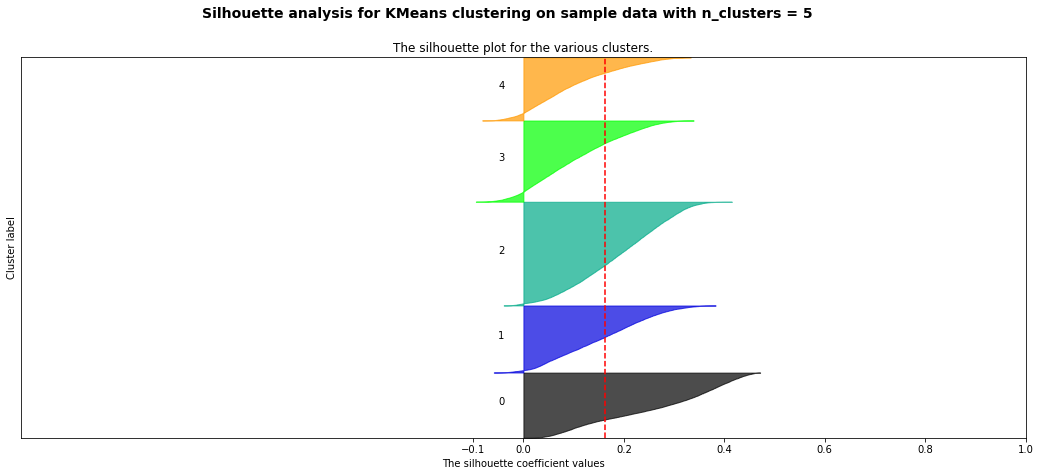

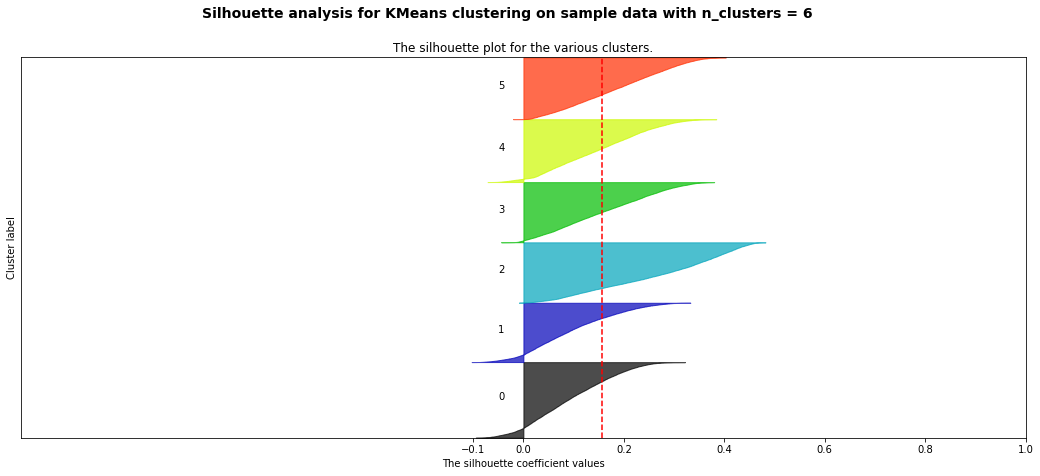

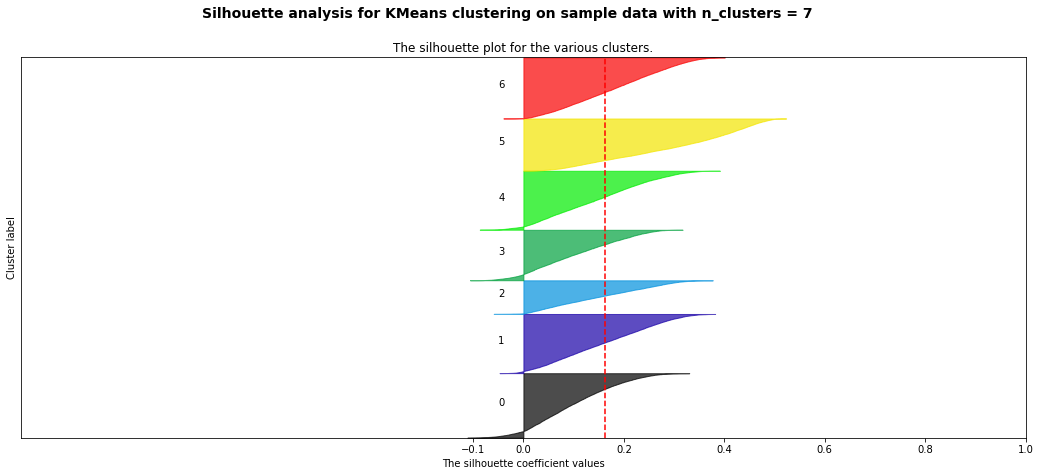

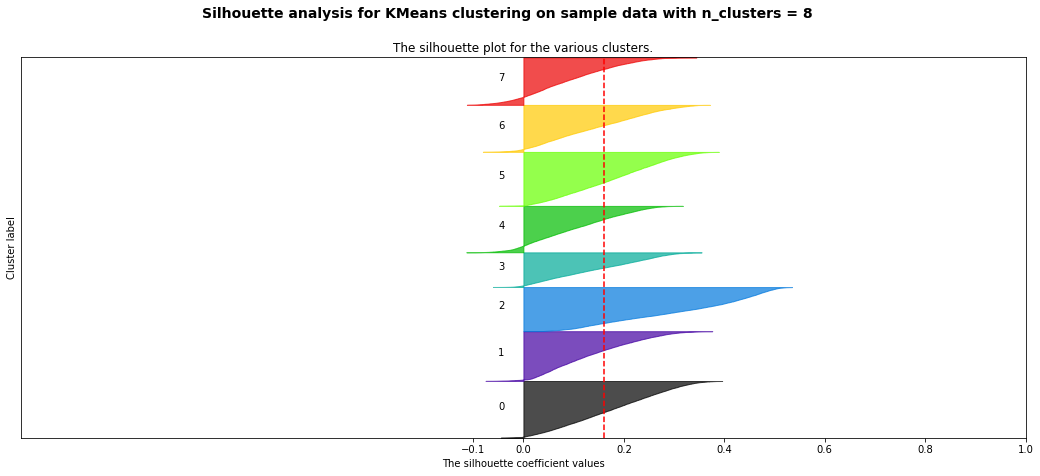

In [7]:
# --- KMeans Classifier ---
range_n_clusters = [5, 6, 7, 8]

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(encoded_data)
    encoded_pred = kmeans.labels_
    pred_clusters = kmeans.cluster_centers_
    # print( pred_clusters)

    # clusters results analysis - the density and separation of the samples in clusters
    # using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b)
    # (b - a) / max(a, b) --> range between [-1,1] (best score = 1)
    silhouette_avg = silhouette_score(encoded_data, encoded_pred)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(encoded_data, encoded_pred)

    # Create a subplot with range_n_clusters row and 1 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(encoded_data) + (n_clusters + 1) * 10])\

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[encoded_pred == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


In [8]:
# --> best silhouette score resulted for 8 clusters
best_clusters_num = 8
# kmeans = KMeans(n_clusters=best_clusters_num, random_state=0).fit(encoded_data)


# Test Model 

In [9]:
encoded_test_data = encoder.predict(x_test)  # bottleneck representation - clustering to 10 classes
encoded_test_pred = kmeans.predict(encoded_test_data)
silhouette_avg = silhouette_score(encoded_test_data, encoded_test_pred)
print("For Test data classified into n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)


For Test data classified into n_clusters = 8 The average silhouette_score is : 0.15782554


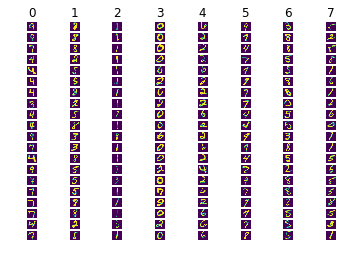

In [10]:
# plot test data results
classes = ['0', '1', '2', '3', '4', '5', '6', '7']
num_classes = len(classes)
samples_per_class = 20
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(encoded_test_pred == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_test[idx].reshape(28,28).astype('float64'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()
